In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

%matplotlib inline
# do the imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers

from keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [ ]:

# unet convolutional block
# convlutional layer, batch norm, and relu for non-linearity
def unet_conv_block(inputs, filters):
  x = layers.Conv2D(filters, 3, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters, 3, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  return x

# filters = number of output features
# encoder => lowers the dimensionality
# allows it to learn features
def unet_encoder(inputs, filters):
  x = unet_conv_block(inputs, filters)
  y = layers.MaxPooling2D((2,2))(x)
  return x, y

# brings the diminseionality back up
# but with the learned borders
def unet_decoder(inputs, skipConnection, filters):
  x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(inputs)
  x = layers.Concatenate()([x, skipConnection])
  x = unet_conv_block(x, filters)
  return x

# build the unet
def unet_build(input_shape):
  inputs = Input(input_shape)

  # encoding section
  x1, y1 = unet_encoder(inputs, 64)
  x2, y2 = unet_encoder(y1, 128)
  x3, y3 = unet_encoder(y2, 256)
  x4, y4 = unet_encoder(y3, 512)

  b1 = unet_conv_block(y4, 1024)

  # encoding section
  d1 = unet_decoder(b1, x4, 512)
  d2 = unet_decoder(d1, x3, 256)
  d3 = unet_decoder(d2, x2, 128)
  d4 = unet_decoder(d3, x1, 64)

  output = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
  model = Model(inputs, output, name = "UNET")
  return model

input_shape = (128, 128, 3)
model = unet_build(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Define the target image size
IMG_HEIGHT = 128
IMG_WIDTH = 128

# load the dataset
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])

    return image, mask

# gets all of the names of the files basically!
def load_dataset(image_dir, mask_dir):
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

    image_paths.sort()
    mask_paths.sort()

    return image_paths, mask_paths

# get the paths
image_dir = r"/content/drive/My Drive/segmentationData/images"
mask_dir = r"/content/drive/My Drive/segmentationData/mask"
image_paths, mask_paths = load_dataset(image_dir, mask_dir)

# Split the dataset into training, validation, and testing sets
train_image_paths, val_test_image_paths, train_mask_paths, val_test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(val_test_image_paths, val_test_mask_paths, test_size=0.5, random_state=42)

# Create TensorFlow Dataset objects
def create_dataset(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda image, mask: load_image_mask(image, mask), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

batch_size = 4
train_dataset = create_dataset(train_image_paths, train_mask_paths, batch_size)
val_dataset = create_dataset(val_image_paths, val_mask_paths, batch_size)
test_dataset = create_dataset(test_image_paths, test_mask_paths, batch_size)

# Assuming you have already built your U-Net model and named it `model`
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 25
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


Epoch 1/25
28/28 [==============================] - 34s 470ms/step - loss: 0.1775 - accuracy: 0.9277 - val_loss: 9.3630 - val_accuracy: 0.5725
Epoch 2/25
28/28 [==============================] - 3s 103ms/step - loss: 0.1816 - accuracy: 0.9281 - val_loss: 4.1268 - val_accuracy: 0.7291
Epoch 3/25
28/28 [==============================] - 3s 113ms/step - loss: 0.1373 - accuracy: 0.9466 - val_loss: 1.9903 - val_accuracy: 0.7271
Epoch 4/25
28/28 [==============================] - 3s 104ms/step - loss: 0.1072 - accuracy: 0.9571 - val_loss: 1.2799 - val_accuracy: 0.8351
Epoch 5/25
28/28 [==============================] - 3s 104ms/step - loss: 0.0901 - accuracy: 0.9640 - val_loss: 0.7761 - val_accuracy: 0.8333
Epoch 6/25
28/28 [==============================] - 3s 114ms/step - loss: 0.0851 - accuracy: 0.9657 - val_loss: 0.4408 - val_accuracy: 0.8864
Epoch 7/25
28/28 [==============================] - 3s 110ms/step - loss: 0.0928 - accuracy: 0.9635 - val_loss: 0.7627 - val_accuracy: 0.8562
Epoch

1/1 [==============================] - 1s 598ms/step


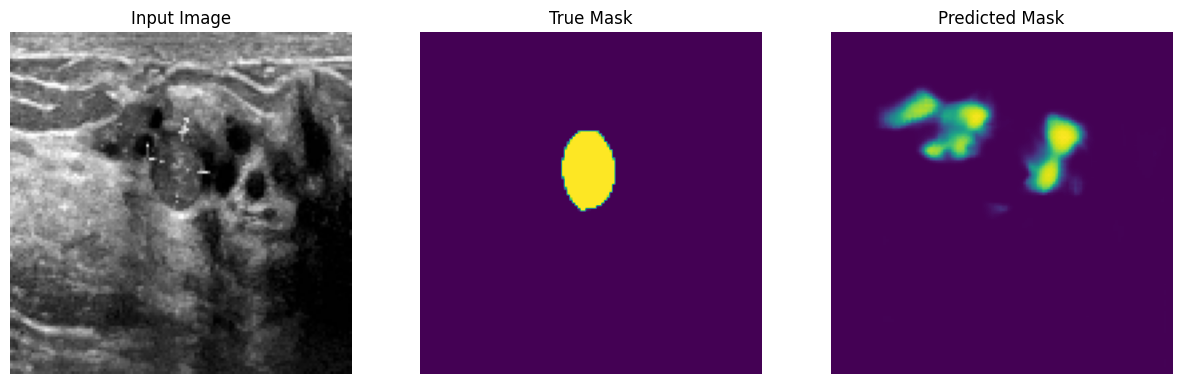

1/1 [==============================] - 0s 24ms/step


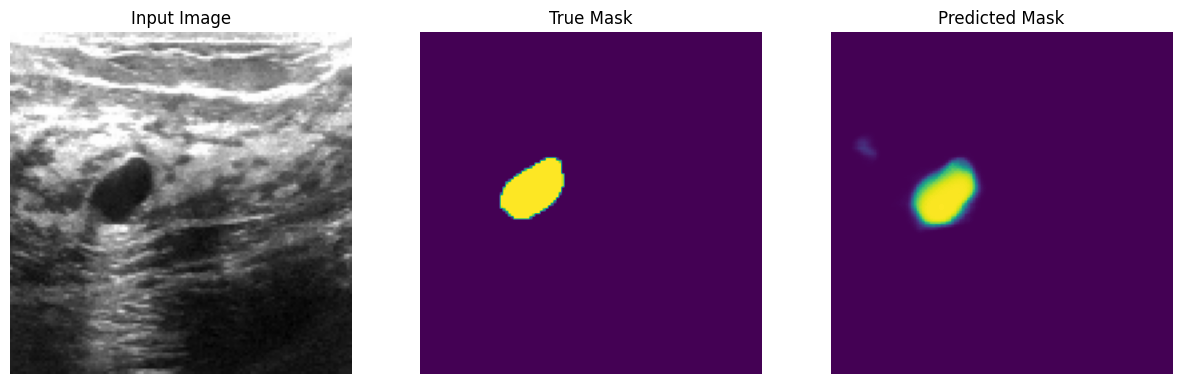

1/1 [==============================] - 0s 19ms/step


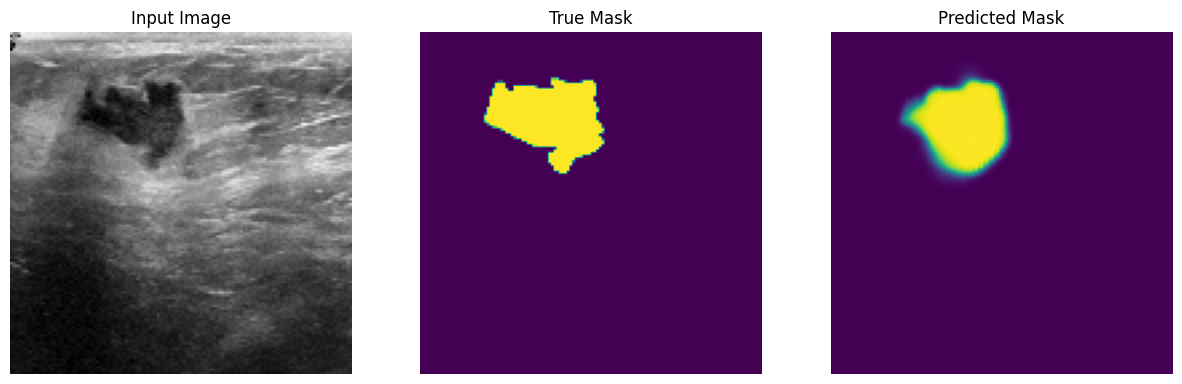

1/1 [==============================] - 0s 29ms/step


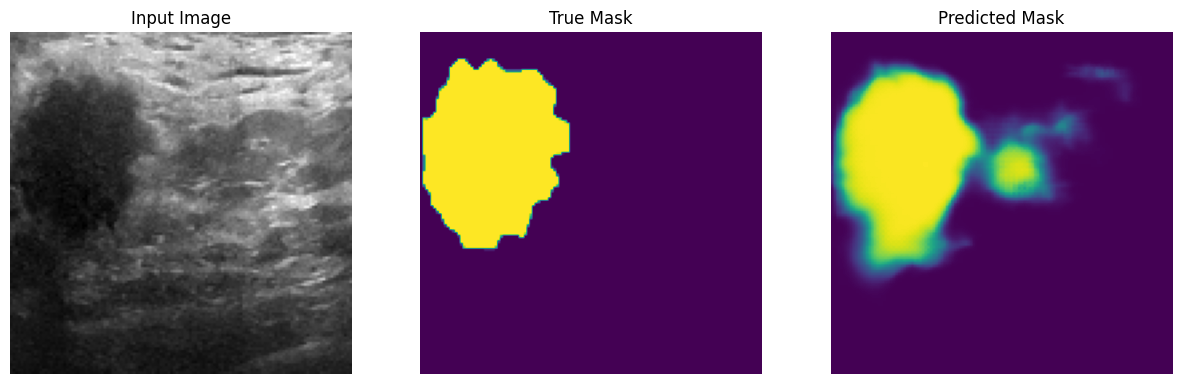

1/1 [==============================] - 0s 29ms/step


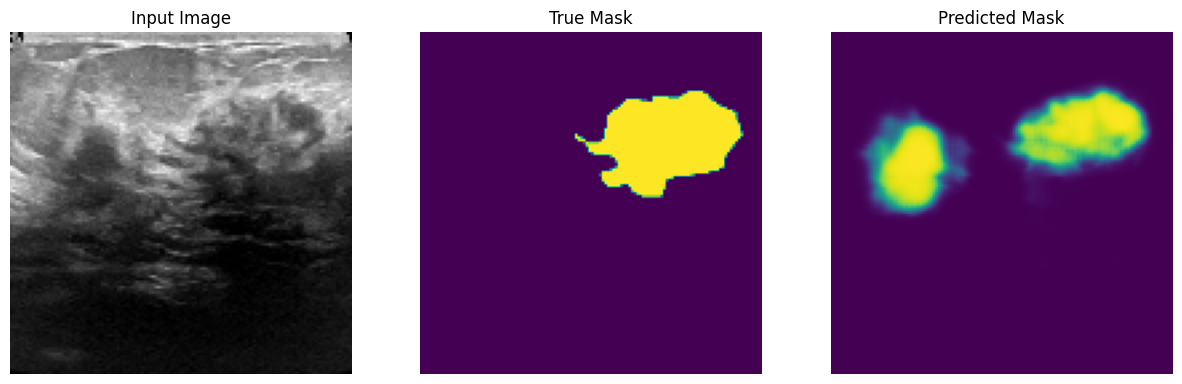

In [ ]:
# Function to display image, ground truth mask, and predicted mask
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Get multiple batches from the test dataset and display them
num_batches_to_display = 5  # Number of batches to display
for i, (image, mask) in enumerate(test_dataset.take(num_batches_to_display)):
    image = tf.expand_dims(image[0], axis=0)  # Add batch dimension
    pred_mask = model.predict(image)
    display([image[0], mask[0], pred_mask[0]])

In [ ]:
print(len(test_dataset))

6
